In [13]:
import numpy as np
from os.path import join
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
import umap
import sys
import importlib
import torch
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow
%matplotlib inline

# Init

In [2]:
PROJ_DIR = '/home/gcgreen2/neurips_comp'
DATA_DIR = join(PROJ_DIR, 'data')
OUT_DIR = join(PROJ_DIR, 'out', '1-3_avg_b')

In [3]:
sys.path.append(join(PROJ_DIR,'cae'))
from scripts import models, utils

In [14]:
importlib.reload(models)

<module 'scripts.models' from '/home/gcgreen2/neurips_comp/cae/scripts/models.py'>

In [4]:
with open(join(OUT_DIR,'config.py'), 'r') as fh:
    lines = fh.read()
    eval(compile(lines, '<string>', 'exec'))

## Load data & model

In [5]:
adata_mod1 = ad.read_h5ad(par['data_mod1'])
adata_mod2 = ad.read_h5ad(par['data_mod2'])

In [6]:
mod1_pca = np.load(files['mod1_pca'])
mod2_pca = np.load(files['mod2_pca'])

In [7]:
adata_mod1.obsm['X_pca'] = mod1_pca
adata_mod2.obsm['X_pca'] = mod2_pca

In [8]:
adata_mod1.obs['mod'] = 'mod1'
adata_mod2.obs['mod'] = 'mod2'

In [15]:
model = eval(utils.model_str(par))
model.load_state_dict(torch.load(files['model']))

<All keys matched successfully>

## Get latent space repr. and perform clustering

In [16]:
X,Y = [torch.FloatTensor(data.obsm['X_pca']) for data in [adata_mod1,adata_mod2]]
_,_,Z_mod1,Z_mod2 = model(X,Y)
Z_mod1, Z_mod2 = [z.detach().numpy() for z in [Z_mod1, Z_mod2]]

In [17]:
adata_mod1.obsm['Z'] = Z_mod1
adata_mod2.obsm['Z'] = Z_mod2

In [18]:
# Z = np.concatenate((Z_mod1,Z_mod2), axis=0)
# Z_umap = umap.UMAP().fit_transform(Z)

In [19]:
# adata_mod1.obsm['Z_umap'] = Z_umap[:len(Z_umap)//2]
# adata_mod2.obsm['Z_umap'] = Z_umap[len(Z_umap)//2:]

In [20]:
tsne_path = join(OUT_DIR, 'tsne.npy')
if os.path.exists(tsne_path):
    Z_tsne = np.load(tsne_path, allow_pickle=True)
else:
    Z = np.concatenate((Z_mod1,Z_mod2), axis=0)
    Z_tsne = TSNE(2).fit_transform(Z)
    np.save(tsne_path, Z_tsne)

In [21]:
adata_mod1.obsm['Z_tsne'] = Z_tsne[:len(Z_tsne)//2]
adata_mod2.obsm['Z_tsne'] = Z_tsne[len(Z_tsne)//2:]

## Add test and train info

In [22]:
idx_train = np.loadtxt(files['idx_train'], dtype=int)
idx_test = np.loadtxt(files['idx_test'], dtype=int)

In [23]:
is_train = np.full(len(adata_mod1), True)
is_train[idx_test] = False

In [24]:
adata_mod1.obs['is_train'] = is_train
adata_mod2.obs['is_train'] = is_train

In [25]:
# mod1_train, mod2_train, mod1_test, mod2_test = \
#     [adata[idx] for idx in [idx_train, idx_test] for adata in [adata_mod1,adata_mod2]]

# Latent space plots

In [26]:
adata_mod1.obs.head(1)

,pct_counts_mt,n_counts,n_genes,size_factors,phase,cell_type,pseudotime_order_GEX,batch,pseudotime_order_ATAC,is_train,mod
TAGTTGTCACCCTCAC-1-s1d1,1.061008,1508.0,1022.0,0.453484,S,Naive CD20+ B,NaN,s1d1,NaN,True,mod1


In [27]:
def plot_latent(mod1, mod2, col, train_test='all', clustering='Z_tsne'):
    if train_test != 'all':
        idx = np.where(mod1.obs['is_train'] == (train_test=='train'))
        mod1 = mod1[idx]
        mod2 = mod2[idx]
        
    labels = set(np.unique(mod1.obs[col]))
    labels.update(np.unique(mod2.obs[col]))
    colors = rainbow(np.linspace(0,1,len(labels),endpoint=False), alpha=0.2)
    
    plt.figure(figsize=(9,7))
    plt.title(col + ', latent space')
    for i,label in enumerate(labels):
        cur_mod1 = mod1[np.where(mod1.obs[col] == label)].obsm[clustering]
        cur_mod2 = mod2[np.where(mod2.obs[col] == label)].obsm[clustering]
        x = np.concatenate((cur_mod1[:,0], cur_mod2[:,0]), axis=0)
        y = np.concatenate((cur_mod1[:,1], cur_mod2[:,1]), axis=0)
        plt.plot(x, y, 'o', color=colors[i], label=label)
        
    leg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    for lh in leg.legendHandles: 
        lh._legmarker.set_alpha(1)

### Modality

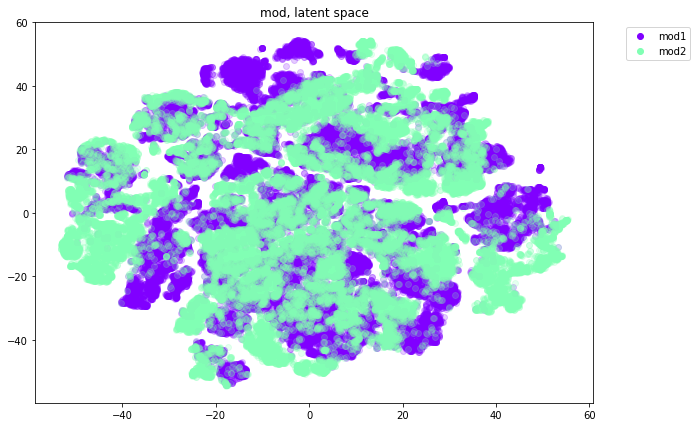

In [28]:
plot_latent(adata_mod1, adata_mod2, 'mod', 'train')

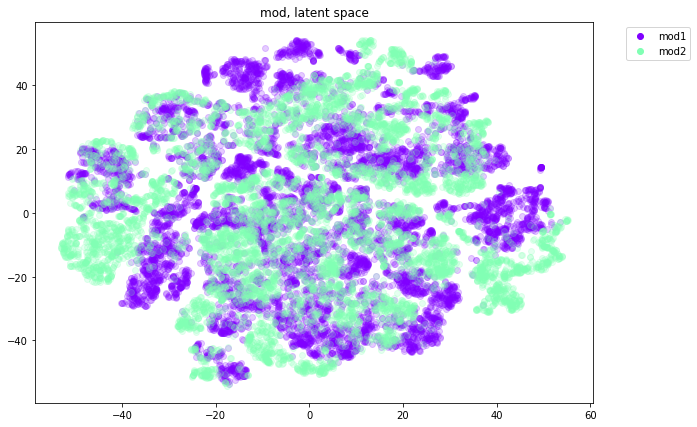

In [29]:
plot_latent(adata_mod1, adata_mod2, 'mod', 'test')

### Cell type

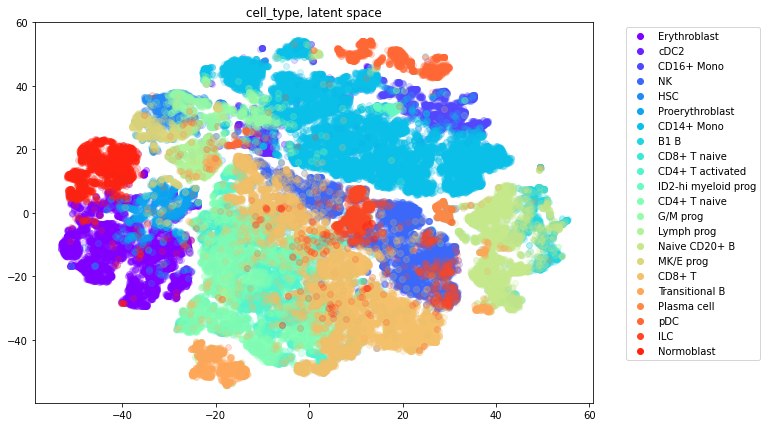

In [30]:
plot_latent(adata_mod1, adata_mod2, 'cell_type', 'train')

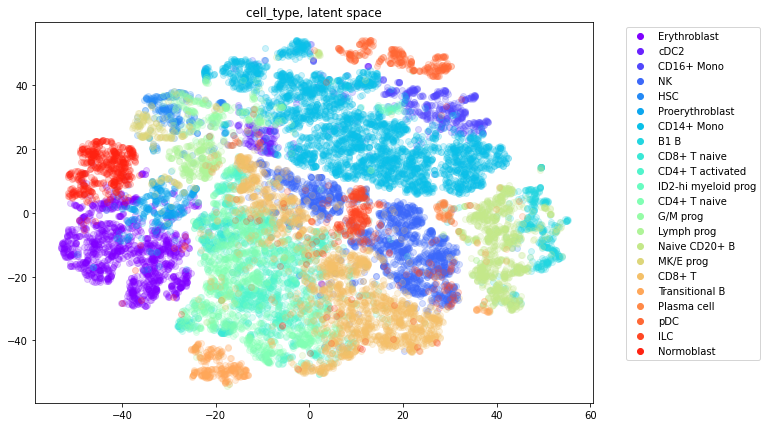

In [31]:
plot_latent(adata_mod1, adata_mod2, 'cell_type', 'test')

### Batch

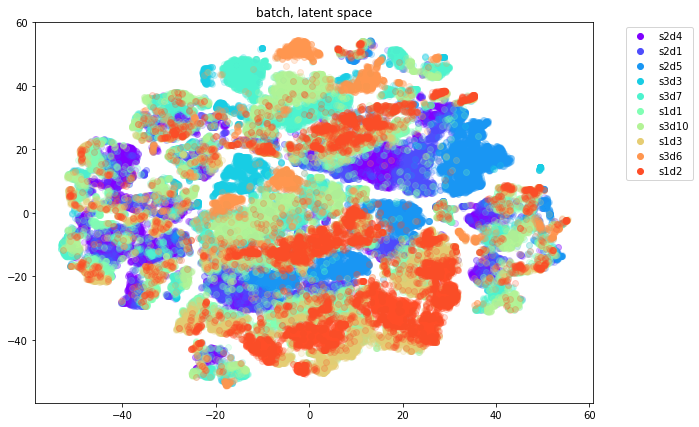

In [32]:
plot_latent(adata_mod1, adata_mod2, 'batch', 'train')

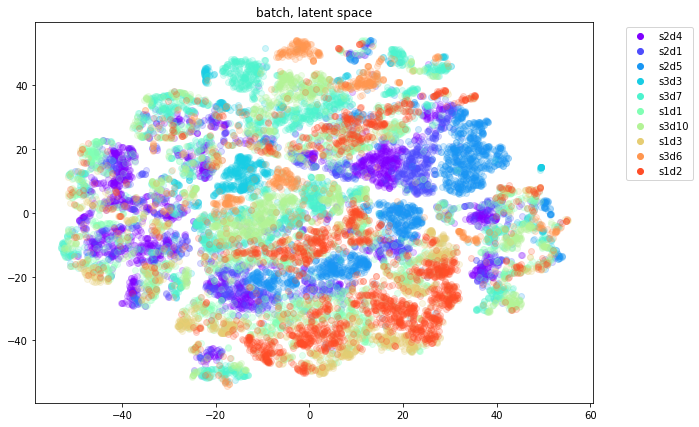

In [33]:
plot_latent(adata_mod1, adata_mod2, 'batch', 'test')

### Train vs test

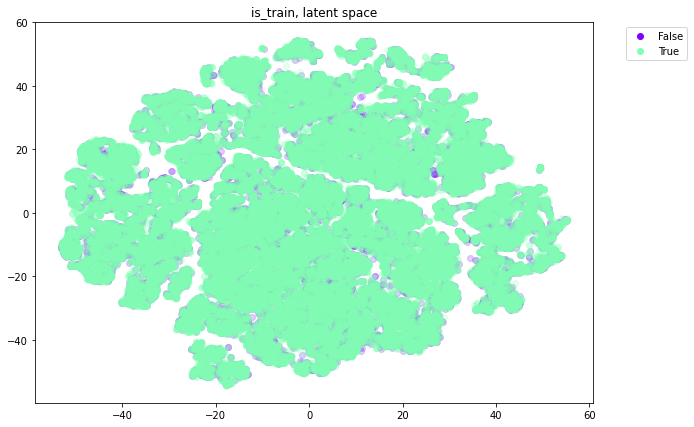

In [34]:
plot_latent(adata_mod1, adata_mod2, 'is_train', 'all')